In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",  # to make plots like loss curves
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights sicne GPT-2 was trained on TF
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tensorflow version: 2.19.0


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class LayerNormalization(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(variance + self.eps)
        return self.scale * norm_x + self.shift


class MultiHeadAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg["emb_dim"]
        self.n_heads = cfg["n_heads"]
        self.head_dim = self.emb_dim // self.n_heads
        self.qkv_proj = nn.Linear(self.emb_dim, 3 * self.emb_dim, bias=cfg["qkv_bias"])
        self.out_proj = nn.Linear(self.emb_dim, self.emb_dim)
        self.drop_out = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        batch_size, context_length, emb_dim = x.size()

        qkv = self.qkv_proj(x)
        qkv = qkv.view(batch_size, context_length, self.n_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # (batch_size, n_heads, context_length, 3 * head_dim)
        q, k, v = qkv.chunk(3, dim=-1)

        # scaled dot-product attention
        attn_scores = q @ k.transpose(2, 3) / (self.head_dim**0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.drop_out(attn_weights)

        output = (attn_weights @ v).transpose(1, 2) # (batch_size, context_length, n_heads, head_dim)
        output = output.reshape(batch_size, context_length, emb_dim)
        output = self.out_proj(output)
        return output


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self, x):
        return self.ffn(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(cfg)
        self.ffn = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["emb_dim"])
        self.norm2 = LayerNormalization(cfg["emb_dim"])
        self.drop_out = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # x = x + self.drop_out(self.att(self.norm1(x))) # original GPT-2, w/ post-norm
        # x = x + self.drop_out(self.ffn(self.norm2(x))) # original GPT-2, w/ post-norm
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_out(x)
        x = x + shortcut # pre-norm

        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.drop_out(x)
        x = x + shortcut # pre-norm

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNormalization(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, context_length = in_idx.size()

        tok_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(context_length, device=in_idx.device))

        x = tok_emb + pos_emb
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 254, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

matplotlib version: 3.10.0
torch version: 2.9.0+cu126
tiktoken version: 0.12.0
[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<

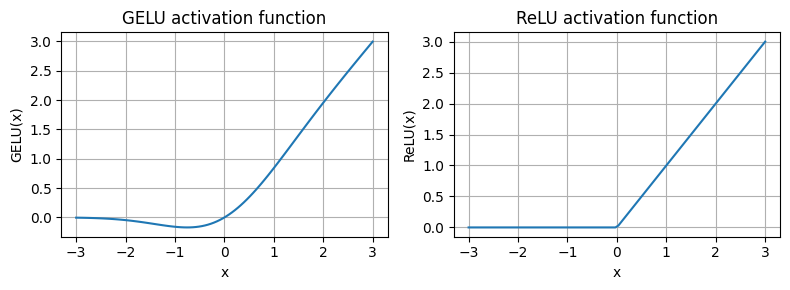

768
torch.Size([2, 3, 768])
layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031
layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576
tensor([[[-0.4254, -0.6054],
         [-0.4180, -0.5809],
         [-0.3952, -0.5214],
         [-0.4177, -0.5277]],

        [[-0.4254, -0.6054],
         [-0.3711, -0.6057],
         [-0.3883, -0.6245],
         [-0.4437, -0.5707]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 4, 2])
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 7

In [3]:
# use this if we can import

import torch
from gpt_from_scratch_to_generate_texts import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 254, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [4]:
import tiktoken
from gpt_from_scratch_to_generate_texts import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension since our model
    # expects inputs to be in batch
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist()) # .tolist() converts tensor to a python list

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you poisonssetup headache missionary Governorsgee Purg salty Kramer �


We as humans can look at this text and say that this is not good enough. But, how do we quantify this in numeric form?

##Calculating the text generation loss: cross-entropy and perplexity

In [5]:
# Let's create an inputs and a targets tensor containing the token ids.

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [6]:
inputs.shape, targets.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

In [7]:
# and when we pass this to the model, we get we obtain the logits vector for the 2 input examples that consist of 3 tokens each
# Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary.
# Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores.
# for each token, the highest value in that dimensional vector is the predicted target.

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)
probas

torch.Size([2, 3, 50257])


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [8]:
token_ids = torch.argmax(probas, dim=-1)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[29549, 45972, 26966],
        [ 7703, 46784, 37308]])


In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  knowledgeable couponsthemed


We get outputs that do not make sense because we haven't trained the model yet.

To train the model, we need to know how far off it is from the actual correct predictions.



In [10]:
probas

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [11]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
# this tells us : for the actual correct target, how confident the model was in it's output

# so if we look at probas, we see that it gives us the probability for each word in the vocabulary
# but since the model is untrained, we do not know whether it is correct or not
# what we are essentially doing here is extracting the correct target's token id for each token
# and then getting the probability that the output gave us fort THAT token id
# if our actual target's token id was say 506, this gives us the prob that the output gave us at that position
# we can see that the prob is mostly 0 here since the model is untrained

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([0.0000, 0.0000, 0.0000])
Text 2: tensor([0.0000, 0.0000, 0.0000])


We want to maximize all these values, bringing them close to a probability of 1.

In [12]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# we are first concatenating the 6 results ( 3 from batch 0 and 3 from batch 1)
# then taking the log value for each values
# Because probabilities are tiny (close to 0).
# Logs turn tiny numbers into negative numbers.

# If probability is high, log is closer to 0

# If probability is low, log is a big negative number

# So:

# Higher probability → closer to 0
# Lower probability → more negative

tensor([-10.4552, -11.3223, -10.4974, -10.9309, -11.2759, -10.4745])


In [13]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

# This means : On average, the model gives about -10.8765  probability
# to the correct token.

tensor(-10.8260)


The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

##Cross-Entropy-Loss

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.


The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

In [14]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas) # The value that this gives is the cross-entropy-loss.

tensor(10.8260)


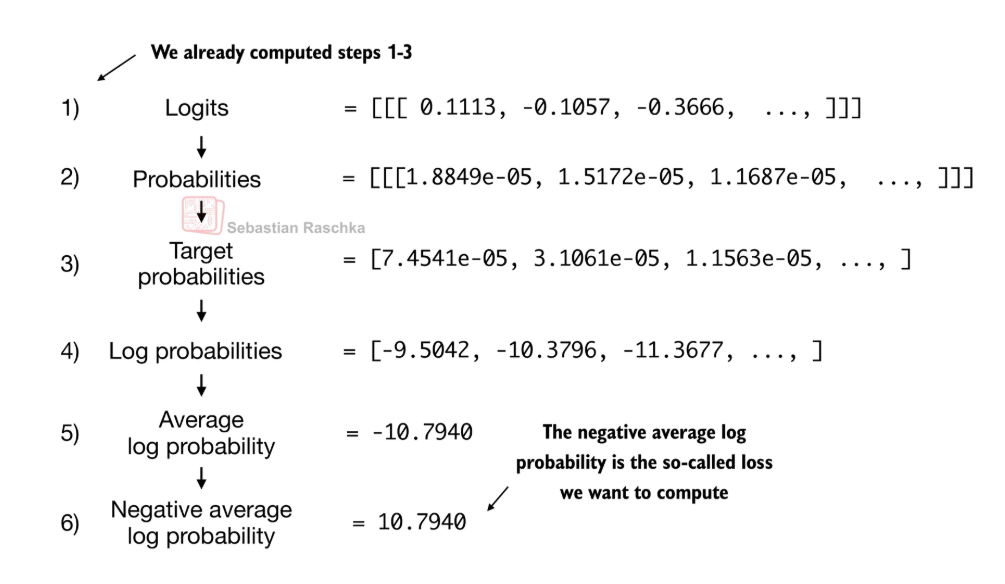

PyTorch has a built-in CrossEntropy Function.

In [15]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [16]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Logits:", logits_flat)
print("\nTargets:", targets_flat) #
print("\nFlattened logits:", logits_flat)
print("\nFlattened targets:", targets_flat)
print("\nFlattened logits shape:", logits_flat.shape)
print("\nFlattened targets shape:", targets_flat.shape)
# Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize

Logits: tensor([[ 0.3093,  0.5073,  0.9590,  ..., -0.1740, -0.4528,  0.1034],
        [ 1.0439, -0.6106, -0.0194,  ..., -0.6059,  0.4432,  0.5450],
        [ 0.6430, -0.0400,  0.9770,  ..., -0.2784, -0.4991,  0.5595],
        [ 0.4641,  0.9146,  0.9343,  ..., -0.2449, -1.9361, -0.3988],
        [ 0.9641, -0.8507, -0.5159,  ...,  0.3883,  0.3412,  0.0372],
        [ 0.1302, -0.6835,  0.7893,  ..., -0.1855,  0.3611, -0.6619]])

Targets: tensor([ 3626,  6100,   345,  1107,   588, 11311])

Flattened logits: tensor([[ 0.3093,  0.5073,  0.9590,  ..., -0.1740, -0.4528,  0.1034],
        [ 1.0439, -0.6106, -0.0194,  ..., -0.6059,  0.4432,  0.5450],
        [ 0.6430, -0.0400,  0.9770,  ..., -0.2784, -0.4991,  0.5595],
        [ 0.4641,  0.9146,  0.9343,  ..., -0.2449, -1.9361, -0.3988],
        [ 0.9641, -0.8507, -0.5159,  ...,  0.3883,  0.3412,  0.0372],
        [ 0.1302, -0.6835,  0.7893,  ..., -0.1855,  0.3611, -0.6619]])

Flattened targets: tensor([ 3626,  6100,   345,  1107,   588, 11311])

The reason we do this is because  the Cross-Entropy function in PyTorch expects :   


```
logits: (N, vocab_size)
targets: (N)
```




In [17]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8260)


##Perplexity

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

In [18]:
perplexity = torch.exp(loss)
perplexity

tensor(50312.7852)

Perplexity tells us about how confused our Language Model is.

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 52916.6055 words or tokens).


In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.


Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution



##Calculating the training and validation set losses

In [19]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [20]:
print(text_data[:50])
# Last 99 characters
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap g
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Now, we ae going to divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.

In [22]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
  # max_length is how many token_ids the model sees at once
  # if we set max_length as 10, it sees the first 10 token in the first step
  # and those first 10 are stored as a single row in the input_ids list
  # it's the same for target as well.
  # and stride is how much we will slide over in the next iteration of the sequence
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
    assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"


  # Use a sliding window to chunk the book into overlapping sequences of max_length
    for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [23]:
def create_dataloader_v1(txt, batch_size, max_length,
                         stride, shuffle, drop_last,
                         num_workers):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [24]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [25]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [26]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape) # (batch_size, sequence_length_of_the_sample)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])
torch.Size([2, 254]) torch.Size([2, 254])

Validation loader:
torch.Size([2, 254]) torch.Size([2, 254])


In [27]:
train_tokens = 0
# We are going to count the total tokens in the training and validation dataloader.

for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() # tensor.numel() = number of elements inside the tensor

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)


Training tokens: 4572
Validation tokens: 508
All tokens: 5080


In [28]:
logits,logits.flatten(0,1)

(tensor([[[ 0.3093,  0.5073,  0.9590,  ..., -0.1740, -0.4528,  0.1034],
          [ 1.0439, -0.6106, -0.0194,  ..., -0.6059,  0.4432,  0.5450],
          [ 0.6430, -0.0400,  0.9770,  ..., -0.2784, -0.4991,  0.5595]],
 
         [[ 0.4641,  0.9146,  0.9343,  ..., -0.2449, -1.9361, -0.3988],
          [ 0.9641, -0.8507, -0.5159,  ...,  0.3883,  0.3412,  0.0372],
          [ 0.1302, -0.6835,  0.7893,  ..., -0.1855,  0.3611, -0.6619]]]),
 tensor([[ 0.3093,  0.5073,  0.9590,  ..., -0.1740, -0.4528,  0.1034],
         [ 1.0439, -0.6106, -0.0194,  ..., -0.6059,  0.4432,  0.5450],
         [ 0.6430, -0.0400,  0.9770,  ..., -0.2784, -0.4991,  0.5595],
         [ 0.4641,  0.9146,  0.9343,  ..., -0.2449, -1.9361, -0.3988],
         [ 0.9641, -0.8507, -0.5159,  ...,  0.3883,  0.3412,  0.0372],
         [ 0.1302, -0.6835,  0.7893,  ..., -0.1855,  0.3611, -0.6619]]))

In [29]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
  # Flattening is just removing the batch so that we can compare each row to the targets.

  return loss

def calc_loss_loader(model, data_loader, device, num_batches = None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
  return total_loss / num_batches

In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(model, train_loader, device)
    val_loss   = calc_loss_loader(model, val_loader, device)


print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cpu device.
Training loss: 10.97800318400065
Validation loss: 11.052067756652832


## Training an LLM

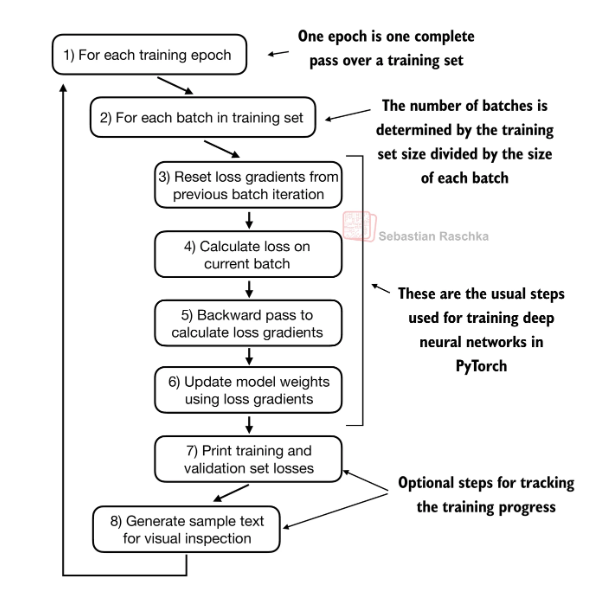

If eval_freq = 200, then after every 200 training steps, we run:

calculate training loss (on a few batches)

calculate validation loss

print the losses

record tokens seen

So eval_freq controls when evaluation happens during training.


---
If eval_iter = 20:

Then during each evaluation:

look at 20 train batches

look at 20 validation batches

average their loss
→ this gives a quick estimate of the model’s performance.



In [34]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

  # eval_freq - How often we need to evaluate.
  # it uses the first n batches always
  # eval_iter — How many batches to use for evaluation.
  # start_context = the initial text given to the model so it can generate the rest, used for the demo of the model's output
  # (not testing)
  # global_step counts the total number of batches the model has seen so far, across all epochs.
  # assuming there are 2 epochs with 2 batches each, the total global_step = 3 at the end.


    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()  # .numel() = number of tokens inside the batch
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        # Fix: Swapped 'train_loader' and 'model' arguments.
        train_loss = calc_loss_loader(model, train_loader, device, num_batches=eval_iter)
        # Fix: Swapped 'val_loader' and 'model' arguments.
        val_loss = calc_loss_loader(model, val_loader, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [35]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.668, Val loss 9.995
Ep 1 (Step 000005): Train loss 8.022, Val loss 8.276
Every effort moves you,,, the,,, the,,,,, the,, the,,,, the, the,,,, the the,,,,, the,, the,,,, the the,, the,,
Ep 2 (Step 000010): Train loss 6.691, Val loss 7.125
Ep 2 (Step 000015): Train loss 6.074, Val loss 6.628
Every effort moves you, the, the, the, the, the, the, the, the, the, the, the, the, the, the the the, the, the, the, the the, the, the, the, the the, the
Ep 3 (Step 000020): Train loss 5.768, Val loss 6.647
Ep 3 (Step 000025): Train loss 5.227, Val loss 6.327
Every effort moves you.    "I had. Gisburn, and was, and, and, and.        "--and, and my, and.   "I had to the picture, and
Ep 4 (Step 000030): Train loss 4.782, Val loss 6.348
Ep 4 (Step 000035): Train loss 4.420, Val loss 6.233
Every effort moves you knowburn, and, and, and, and Mrs. Gisburn, and it was, and in the picture of the of Jack's the, and his, and my, and he had been of the picture to have of the, an

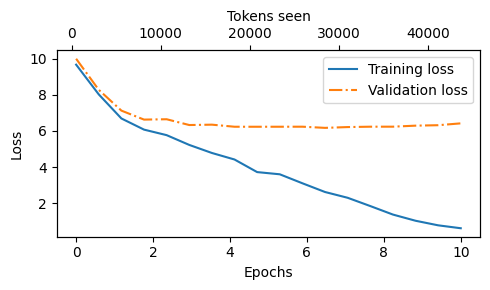

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Text-Generation/ Decoding Strategies to Control Randomness

With the way we are generating text right now, it's no surprise that the model is over-fitting. It is deterministic ( meaning same everytime ). During training, we want it to learn like that but overfitting is not good. If we look at the ouput, the model has basically memorized the training data.

But during inference, we don't want this. We want the model to be creative.

There are various techniques that we can use to make the model more creative. These techniques are called decoding strategies.



In [37]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
# Even if we execute the generate_text_simple function above multiple times, the LLM will always generate the same outputs.
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know, I claimed it tells his whole history. There are years of it all--as he had been through, and in


##1. Temperature Scaling

Previously, we always sampled the token with the highest probability as the next token using torch.argmax.


To add variety, we can sample the next token using The torch.multinomial(probs, num_samples=1), sampling from a probability distribution.

This is a creativity dial for model.

In [39]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


## torch.multinomial ( probas, num_samples )

It randomly picks an index based on probabilities.

num_samples refers to how many items we want to draw from the distribution but since we are doing text-generation, we normally just use 1.



```
probs = [0.7, 0.2, 0.1]
torch.multinomial(torch.tensor(probs), 1)

70% of the time → "cat",
20% of the time → "dog" and so on.
```



In [51]:
# What we are going to do here is use torch.multinomial
# so instead of being deteministic and always getting the largest token,
# we will get the token proportional to the probability values
# torch.multinomial expects a probability distribution, so the probabilities must sum to 1.


# torch.manual_seed(123)
next_token_id = torch.multinomial(probas.unsqueeze(0), num_samples=1).item()
print(inverse_vocab[next_token_id])

# If you run this multiple times without torch.manual_seed(), you will see it pick different word.

toward


In [52]:
# running it 1000 times to see how many times it picks different words

def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


We can control the distribution and selection process via a concept called temperature scaling.


"Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0.

Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax. The difference between the higher probability words and low probability words become small making it more likely to pick unusual words, adding creativity.


Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax. It makes the model more confident and deterministic.

In [55]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = []
for T in temperatures :
  scaled_probas.append(softmax_with_temperature(next_token_logits,T))
scaled_probas

[tensor([0.0609, 0.0016, 0.0001, 0.5721, 0.0034, 0.0001, 0.0001, 0.3576, 0.0040]),
 tensor([0.0000, 0.0000, 0.0000, 0.9910, 0.0000, 0.0000, 0.0000, 0.0090, 0.0000]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

In [58]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

scaled_probas

# We notice the difference in the probability distribution for each values of Temperatures.

[tensor([0.0609, 0.0016, 0.0001, 0.5721, 0.0034, 0.0001, 0.0001, 0.3576, 0.0040]),
 tensor([0.0000, 0.0000, 0.0000, 0.9910, 0.0000, 0.0000, 0.0000, 0.0090, 0.0000]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

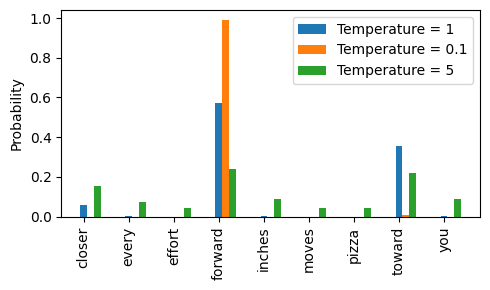

In [59]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [60]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [61]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


Assuming an LLM input "every effort moves you", using the approach above can sometimes result in nonsensical texts, such as "every effort moves you pizza", 3.2% of the time (32 out of 1000 times)

## Top-K Sampling

It picks the k-most probable words. To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens.

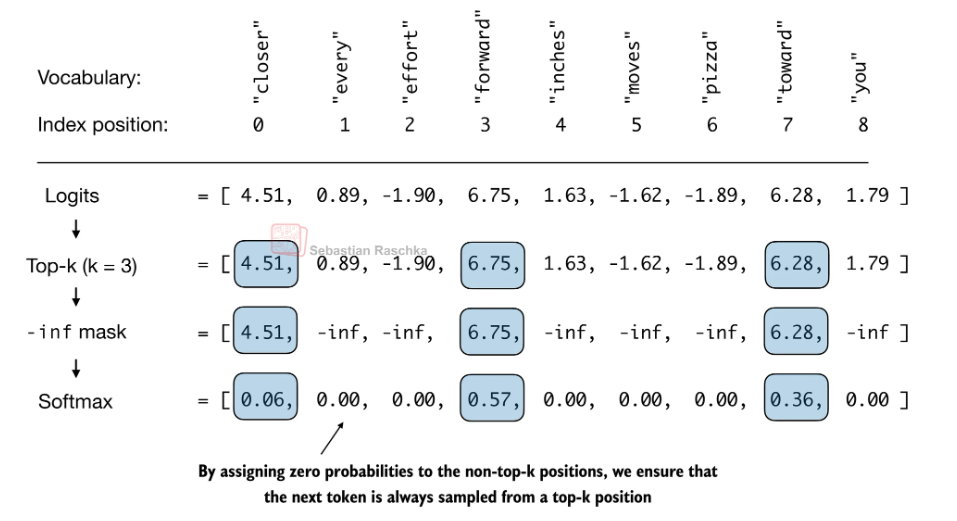

In [62]:
## Top-K Sampling

top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [63]:
# It keeps only the top-k logits (highest scores)
# Everything else is set to -infinity, so it cannot be chosen when sampling.

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    # top_logits is a list of the top_k samples
    # so, from next_token_lists, it checks whether the value is smaller than the
    # smallest value of the top_k or not
    # if yes, then it will be replaced with -inf and if no, it will keep it's original value
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [64]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Modifying the text-generation function

In [67]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Numerical stability tip to get equivalent results on mps device
            # Subtract max logit from each row before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [68]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youteen coat, the thin a straw of his glory that my hostess by


##  Loading and saving model weights in PyTorch

In [69]:
model.state_dict()

OrderedDict([('tok_emb.weight',
              tensor([[ 0.3444, -0.1685, -0.3164,  ..., -0.3250, -1.3882,  0.5253],
                      [ 0.2558,  0.3480, -0.8213,  ..., -0.4138,  0.4974, -0.3787],
                      [ 0.7929,  0.5331,  0.9394,  ..., -1.0710,  0.0951, -1.4087],
                      ...,
                      [-0.7102, -0.5001,  1.4068,  ..., -0.1492, -0.4880, -1.0582],
                      [ 2.0572,  1.1150,  0.3835,  ..., -0.7176, -0.5550,  0.9828],
                      [ 0.0011, -0.7505, -0.1786,  ..., -0.3233,  0.2596,  0.5867]])),
             ('pos_emb.weight',
              tensor([[ 0.8742,  0.2514,  0.8285,  ..., -1.0344,  1.2977,  1.7854],
                      [-0.9993,  0.1001,  1.2457,  ...,  1.5385, -0.1155, -1.5159],
                      [ 1.3256,  0.7635,  0.8994,  ...,  0.0789,  1.8244, -2.2194],
                      ...,
                      [-0.5292,  0.9842, -1.4383,  ...,  1.1332, -0.9663, -0.1069],
                      [-1.0202,  0.5541

In [70]:
torch.save(model.state_dict(), "model.pth")

# We can use torch.load() to load these same weights for another model.

## Loading pretrained weights from OpenAI

In [71]:
! pip install tensorflow tqdm

In [73]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [75]:
# Relative import from the gpt_download.py contained in this folder

from gpt_download import download_and_load_gpt2

In [77]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 197kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 691kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 177kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:17<00:00, 3.61MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 10.8MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 402kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 455kiB/s]


In [78]:
print("Settings:", settings)

print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [79]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [80]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [82]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [83]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [92]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("We are craving", tokenizer).to(device),
    max_new_tokens=30,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 We are craving to know if anyone on there who has any way of identifying me yet knows that I do. My last name is James D. Butterford"
